In [203]:
# http://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot styling
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

## The Data

In [8]:
data = pd.read_csv('data/Fremont_Bridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [9]:
data.columns = ['West','East']
data.fillna(0, inplace=True)
data['Total'] = data['West'] + data['East']

We can get a better idea of the dataset as a whole through a simple visualization; for example, we can resample the data to see the weekly trend in trips over the nearly three-year period:

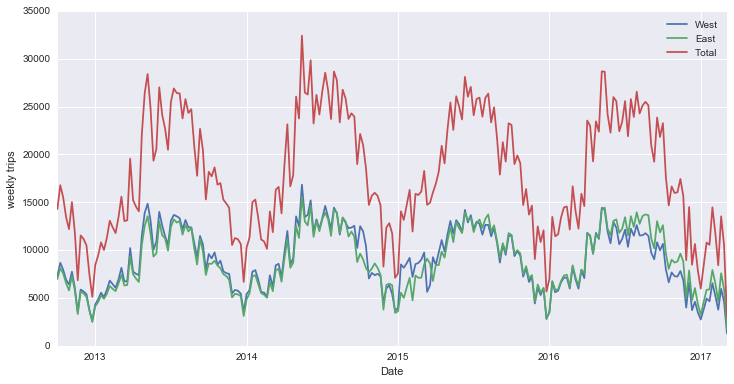

In [16]:
data.resample('W').sum().plot()
plt.ylabel('weekly trips')

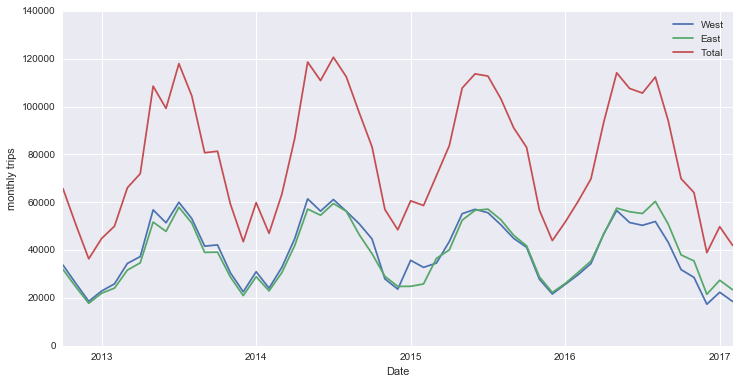

In [17]:
data.resample('M').sum().plot()
plt.ylabel('monthly trips')

The counts show both a strong seasonal variation, as well as a local structure that can be partially accounted for by temperature, time of year, precipitation, and other factors.

## Transforming the Data
The first step in this approach is to transform our data; essentially we will want a two-dimensional matrix, where each row of the matrix corresponds to a day, and each column of the matrix corresponds to one of the 48 observations. We can arrange the data this way using the pivot_table() function in Pandas. We want the "East" and "West" column values, indexed by date, and separated by hour of the day. Any missing values we will fill with zero:

In [23]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

East                                    ... West                 \
             0  1  2  3  4   5   6    7    8    9  ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104 ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94 ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81 ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55 ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36 ...  126  122  132  118   

                                     
             18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [29]:
X = pivoted.values
X.shape

(1610, 48)

Our data consists of just over 1600 days, each with the aforementioned 48 measurements.

## Visualizing the Data

We can think of this data now as representing 1001 distinct objects which live in a 48-dimensional space: the value of each dimension is the number of bicycle trips measured on a particular side of the bridge at a particular hour. Visualizing 48-dimensional data is quite difficult, so instead we will use a standard dimensionality reduction technique to project this to a more manageable size.

The technique we'll use is Principal Component Analysis (PCA) (http://scikit-learn.org/stable/modules/decomposition.html), a fast linear projection which rotates the data such that the projection preserves the maximum variance. We can ask for components preserving 90% of the variance as follows:

In [45]:
from sklearn.decomposition import PCA
Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(1610, 2)

The output has two dimensions, which means that these two projected components describe at least 90% of the total variance in the dataset. While 48-dimensional data is difficult to plot, we certainly know how to plot two-dimensional data: we'll do a simple scatter plot, and for reference we'll color each point according to the total number of trips taken that day:

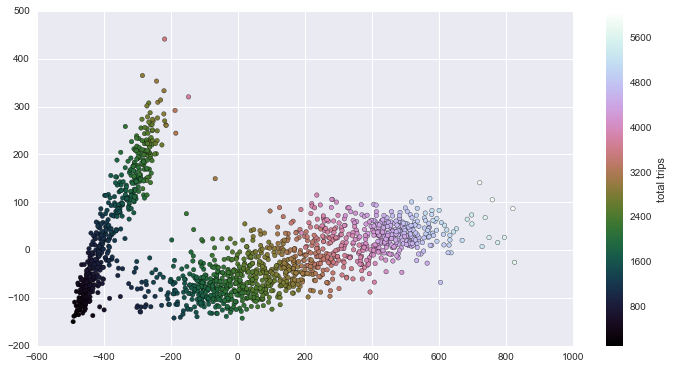

In [46]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips');

We see that the days lie in two quite distinct groups, and that the total number of trips increases along the length of each projected cluster. Further, the two groups begin to be less distinguishable when the number of trips during the day is very small.

I find this extremely interesting: from the raw data, we can determine that there are basically two primary types of days for Seattle bicyclists. Let's model these clusters and try to figure out what these types-of-day are.

## Unsupervised Clustering
When you have groups of data you'd like to automatically separate, but no previously-determined labels for the groups, the type of algorithm you are looking at is a clustering algorithm. There are a number of clustering algorithms out there, but for nicely-defined oval-shaped blobs like we see above, Gaussian Mixture Models (http://scikit-learn.org/stable/modules/mixture.html) are a very good choice. We can compute the Gaussian Mixture Model of the data using, again, scikit-learn, and quickly plot the predicted labels for the points:

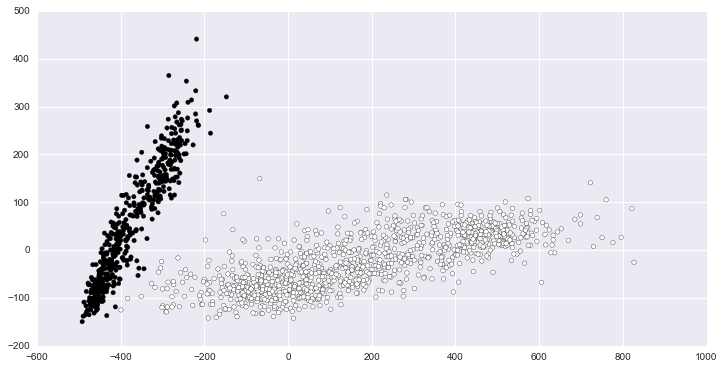

In [65]:
from sklearn.mixture import BayesianGaussianMixture
gmm = BayesianGaussianMixture(2, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label);

This clustering seems to have done the job, and separated the two groups we are interested in. Let's join these inferred cluster labels to the initial dataset:

In [70]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4.0,9.0,13.0,0
2012-10-03 01:00:00,4.0,6.0,10.0,0
2012-10-03 02:00:00,1.0,1.0,2.0,0
2012-10-03 03:00:00,2.0,3.0,5.0,0
2012-10-03 04:00:00,6.0,1.0,7.0,0


Now we can find the average trend by cluster and time using a GroupBy within this updated dataset

In [75]:
by_hour = data.groupby(['Cluster',data.index.time]).mean()
by_hour.head()

West      East      Total
Cluster                                        
0       00:00:00  4.891697  5.841155  10.732852
        01:00:00  2.465704  2.732852   5.198556
        02:00:00  1.870939  1.693141   3.564079
        03:00:00  1.509025  1.250000   2.759025
        04:00:00  4.236462  2.828520   7.064982

Finally, we can plot the average hourly trend among the days within each cluster:

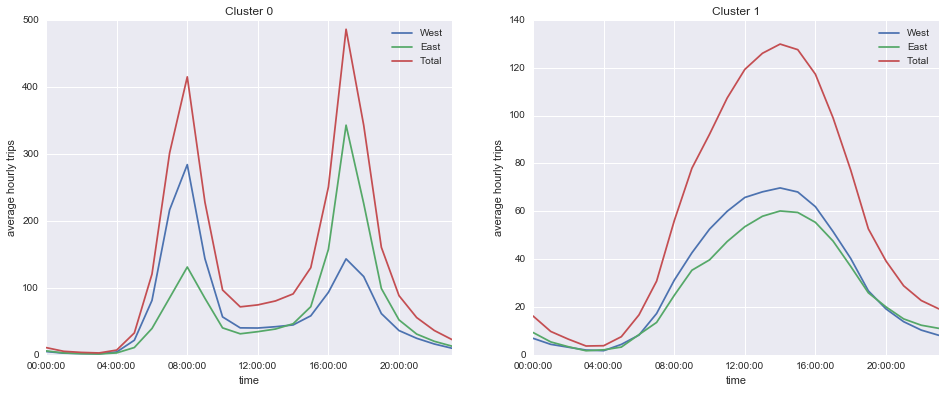

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.ix[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

These plots give us some insight into the interpretation of the two clusters: the first cluster shows a sharp bimodal traffic pattern, while the second shows a wide unimodal pattern.

In the bimodal cluster, we see a peak around 8:00am which is dominated by cyclists on the west sidewalk, and another peak around 5:00pm which is dominated by cyclists on the east sidewalk. This is very clearly a commute pattern, with the majority of cyclists riding toward downtown Seattle in the morning, and away from downtown Seattle in the evening.

In the unimodal cluster, we see fairly steady traffic in each direction beginning early in the morning and going until late at night, with a peak around 2:00 in the afternoon. This is very clearly a recreational pattern of use, with people out riding through the entire day.

I find this is fascinating: from simple unsupervised dimensionality reduction and clustering, we've discovered two distinct classes of days in the data, and found that these classes have very intuitive explanations.

## Seattle's Work Habits

Let's go one step deeper and figure out what we can learn about people (well, bicycle commuters) in Seattle from just this hourly commute data. As a rough approximation, you might guess that these two classes of data might be largely reflective of workdays in the first cluster, and non-work days in the second. We can check this intuition by re-plotting our projected data, except labeling them by day of the week:

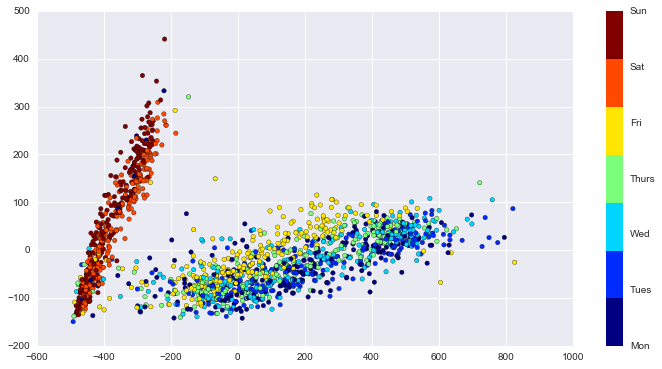

In [103]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

We see that the weekday/weekend intuition holds, but only to a point: in particular, it is clear that there are a handful of weekdays which follow the typical weekend pattern! Further, it's interesting to note that Fridays tend to be pulled closer to weekend days in this plot, though as a whole they still fall solidly in the work-day cluster.

Let's take a closer look at the "special" weekdays that fall in the "wrong" cluster. We start by constructing a dataset listing the cluster id and the day of the week for each of the dates in our dataset:

In [108]:
results  = pd.DataFrame({'cluster': cluster_label,
                         'is_weekend': (dayofweek > 4),
                          'weekday' : pivoted.index.map(lambda x: x.strftime('%a'))},
                          index=pivoted.index)
results.head()

,cluster,is_weekend,weekday
2012-10-03,0,False,Wed
2012-10-04,0,False,Thu
2012-10-05,0,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


First, let's see how many weekend days fall in the first, commute-oriented cluster

In [112]:
results.query('cluster == 0 and is_weekend')

,cluster,is_weekend,weekday


zero! Apparently, there is not a single weekend during the year where Seattle cyclists as a whole decide to go to work.

Similarly, we can see how many weekdays fall in the second, recreation-oriented cluster:

In [114]:
midweek_holidays = results.query('cluster == 1 and not is_weekend')
len(midweek_holidays)

42

There were 42 weekdays over the past several years in which Seattle cyclists as a whole did not go to work. To label these, let's load the US Federal holiday calendar available in Pandas:

In [162]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2018', return_name=True)
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
dtype: object

Just for completeness, we will add to the list the day before and day after each of these holidays:

In [164]:
holidays_all = pd.concat([holidays, 
                         'Day Before ' + holidays.shift(-1, 'D'),
                         'Day After ' + holidays.shift(1, 'D')])
holidays_all.sort_index(inplace=True)
holidays_all.head()

2012-01-01                 Day Before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day After New Years Day
2012-01-15    Day Before Dr. Martin Luther King Jr.
2012-01-16               Dr. Martin Luther King Jr.
dtype: object

Note that these are observed holidays, which is why New Years Day 2012 falls on January 2nd. With this ready to go, we can compute the complete list of non-weekend days on which Seattle bicycle commuters as a whole chose to stay home from work:

In [165]:
holidays_all.name = 'name'
joined = midweek_holidays.join(holidays_all)
joined.head()

,cluster,is_weekend,weekday,name
2012-11-22,1,False,Thu,Thanksgiving
2012-11-23,1,False,Fri,Day After Thanksgiving
2012-12-24,1,False,Mon,Day Before Christmas
2012-12-25,1,False,Tue,Christmas
2012-12-31,1,False,Mon,Day Before New Years Day


In [166]:
joined.name.value_counts(dropna=False)

Day After Thanksgiving      5
New Years Day               5
Thanksgiving                5
Christmas                   5
July 4th                    4
Day Before Christmas        4
Labor Day                   4
MemorialDay                 4
NaN                         3
Day Before New Years Day    2
Day After Christmas         1
Name: name, dtype: int64

In [167]:
joined[joined['name'].isnull()]

,cluster,is_weekend,weekday,name
2016-12-23,1,False,Fri,NaN
2016-12-30,1,False,Fri,NaN
2017-02-06,1,False,Mon,NaN


## Update: What's up with Fridays?
For the most part, Fridays tend to lie on the upper side of the weekday cluster, closer in this parameter space to the typical weekend pattern. This pattern holds nearly universally for Fridays, all except for three strange outliers which lie far on the other side of the cluster.

We can see these more clearly if we highlight the Friday points in the plot:

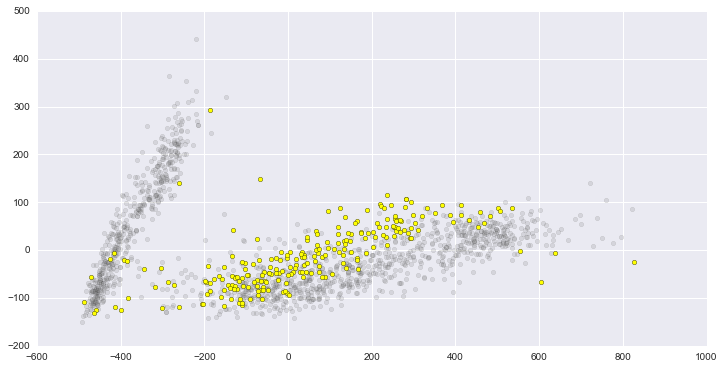

In [173]:
fridays = (dayofweek == 4)
plt.scatter(Xpca[:,0], Xpca[:,1], c='gray', alpha=0.2)
plt.scatter(Xpca[fridays,0], Xpca[fridays,1], c='yellow')

The yellow points in the bottom-right of the plot are unique – they're far different than other Fridays, and they even stand-out in comparison to the other work days! Let's see what they represent:

In [182]:
weird_fridays = pivoted[fridays & (Xpca[:, 0] > 600)]
weird_fridays

East                                      ...   West            \
              0  1  2  3  4   5   6    7    8    9   ...     15   16   17   
2013-05-17    9  6  2  2  1  15  66  115  148   87   ...     76  126  176   
2014-05-16    9  7  1  1  8  19  71  143  189  155   ...    105  149  231   
2015-05-15    7  5  0  3  3  23  86  124  183   75   ...     91  179  215   

                                    Cluster  
             18  19  20  21  22  23          
2013-05-17  121  67  42  40  27  15       0  
2014-05-16  155  89  39  30  22  14       0  
2015-05-15  150  91  45  29  27  19       0  

[3 rows x 49 columns]

All three of these outlying Fridays fall in the middle of May. Curious!

Let's quickly visualize the daily stats for these, along with the mean trend over all days. We can arrange the data this way with a pivot table operation:

In [186]:
data.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4.0,9.0,13.0,0
2012-10-03 01:00:00,4.0,6.0,10.0,0
2012-10-03 02:00:00,1.0,1.0,2.0,0
2012-10-03 03:00:00,2.0,3.0,5.0,0
2012-10-03 04:00:00,6.0,1.0,7.0,0


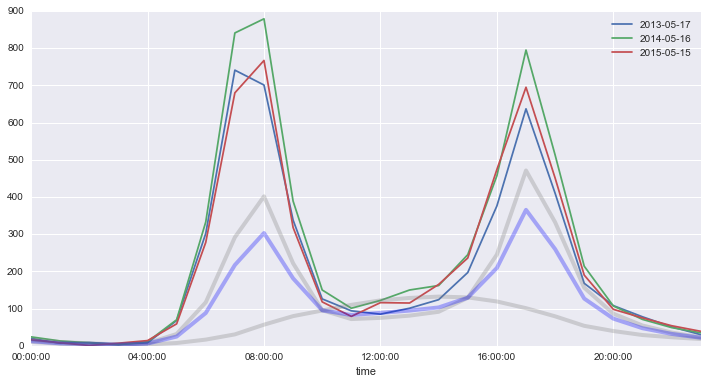

In [201]:
all_days = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
all_days.loc[:, weird_fridays.index].plot()
all_days.loc[:, (dayofweek < 5)].mean(1).plot(color='gray', lw=4, alpha=0.3)
all_days.loc[:, (dayofweek > 4)].mean(1).plot(color='gray', lw=4, alpha=0.3)
all_days.mean(1).plot(color='blue', lw=4, alpha=0.3, xticks=hourly_ticks)

Apparently these three strange Fridays are days with extreme amounts of bicycle commuting. But what makes them so special?

After some poking-around on the internet, the answer becomes clear: we've discovered Seattle's annual bike to work day (http://www.cascade.org/f5-bike-work-day). Mystery solved!